# Classifying Vascular Networks
Jocelyn Shen

###### In this notebook, I will be using SVMs, PCA, and logistic regression to classify networks

<img src="http://faculty.biomath.ucla.edu/vsavage/Assets/Graphics/dicom_small_9_gd_crop_alpha.png",width=250>

### FUNCTIONS:

In [1]:

def process(filename):
    df = pd.read_csv(filename)
    df_null = df[df.isnull().any(axis=1)]
    df = df.drop(df_null.index)
    df_beta_gamma = pd.concat([df['beta.ave'], df['beta.diff'], df['gamma.ave'], df['gamma.diff']], axis=1, 
                           keys=['beta.ave', 'beta.diff', 'gamma.ave', 'gamma.diff'])
    df_beta_gamma = df_beta_gamma.sample(frac=1).reset_index(drop=True)
    return df_beta_gamma

# list_df is the list of dataframes to add to the X training set
# p_train is percentage to take as training set
# class type (0,1,2...)
def train_test_split(list_df, p_train, class_type):
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    for dataframe in list_df:
        dataframe["type"] = np.asarray([class_type for x in range(0,dataframe.shape[0])])
        index = int(dataframe.shape[0]*(p_train/100.00))
        df_train = pd.concat([df_train, dataframe[:index]])
        df_test = pd.concat([df_test, dataframe[index:]])
    df_train = df_train.sample(frac=1).reset_index(drop=True)
    df_test = df_test.sample(frac=1).reset_index(drop=True)
    return df_train, df_test

def generate_train_test(list_df_train, list_df_test, filename):
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    for dataframe in list_df_train:
        df_train = pd.concat([df_train, dataframe])
    for dataframe in list_df_test:
        df_test = pd.concat([df_test, dataframe])
    df_train = df_train.sample(frac=1).reset_index(drop=True)
    df_test = df_test.sample(frac=1).reset_index(drop=True)
    df_train.to_csv('TRAINING_SET_' + filename +'.csv', sep = ",")
    df_test.to_csv('TESTING_SET_' + filename + '.csv', sep = ",")
    return df_train, df_test

def plot(list_training_sets, x1, x2, name):
    c = 0
    figure = plt.figure(figsize = (20,15))
    ax = figure.add_subplot(1,1,1)
    ax.tick_params(axis = 'y', labelsize = 25)
    ax.tick_params(axis='x', labelsize=25)
    for training_set in list_training_sets:
        if(c==0):
            #plt.scatter(training_set[x1], training_set[x2], label = c, s = 40, facecolors='none', edgecolors = 'b')
            ax.scatter(training_set[x1], training_set[x2], label = 'Animal', color = 'b', s = 150)
        if(c==1):
            #plt.scatter(training_set[x1], training_set[x2], label = c, s = 40, facecolors='none', edgecolors = 'r')
            ax.scatter(training_set[x1], training_set[x2], label = 'Plant', color = 'r', s = 150)
        c = c + 1
    ax.legend(loc=1, prop={'size': 50})
    figure.savefig(str(name + ".png"), dpi = 300)
    plt.show()

### Animal Networks vs. Plant Networks

The data I am using is from the AngiCAML version of Angicart software.
1. hht_master is data from 18 human head and torso images (ANIMAL)

2. mouselung_master is data from a mouse lung data (ANIMAL)

3. pinon_master is data from a Pinon tree/pine tree (PLANT)

4. ponderosa_master is data from a 5 sapling ponderosa pine trees (PLANT)

5. root_master is data from a large collection of clumps of tree roots (PLANT)  

6. treetips_master is data from a collection of 50cm long tree tip samples (PLANT) 
    
    a) 30 samples -- 5 individuals from 6 different species
    
    b) "class" distinguishes between angiosperm (AS, flowering plant), and gymnosperm (GS, non-flowering plant).

In [2]:
from itertools import combinations, chain
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.datasets.samples_generator import make_blobs, make_moons, make_circles
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
%matplotlib inline
plt.style.use("fivethirtyeight")

#### Load and Clean Datasets

In [3]:
hht = process("hht_master.csv")
ml = process("hht_master.csv")
pinon = process("pinon_master.csv")
ponderosa = process("ponderosa_master.csv")
root = process("root_master.csv")
treetips = process("treetips_master.csv")

#### Generate Training Set and Testing Set for Each Class

Here, I take 15% of the human head and torso, and mouse lung data as my testing dataset

In [4]:
animal_training, animal_testing = train_test_split([hht, ml], 85, 1)
plant_training, plant_testing = train_test_split([pinon, ponderosa, root, treetips], 85, 0)

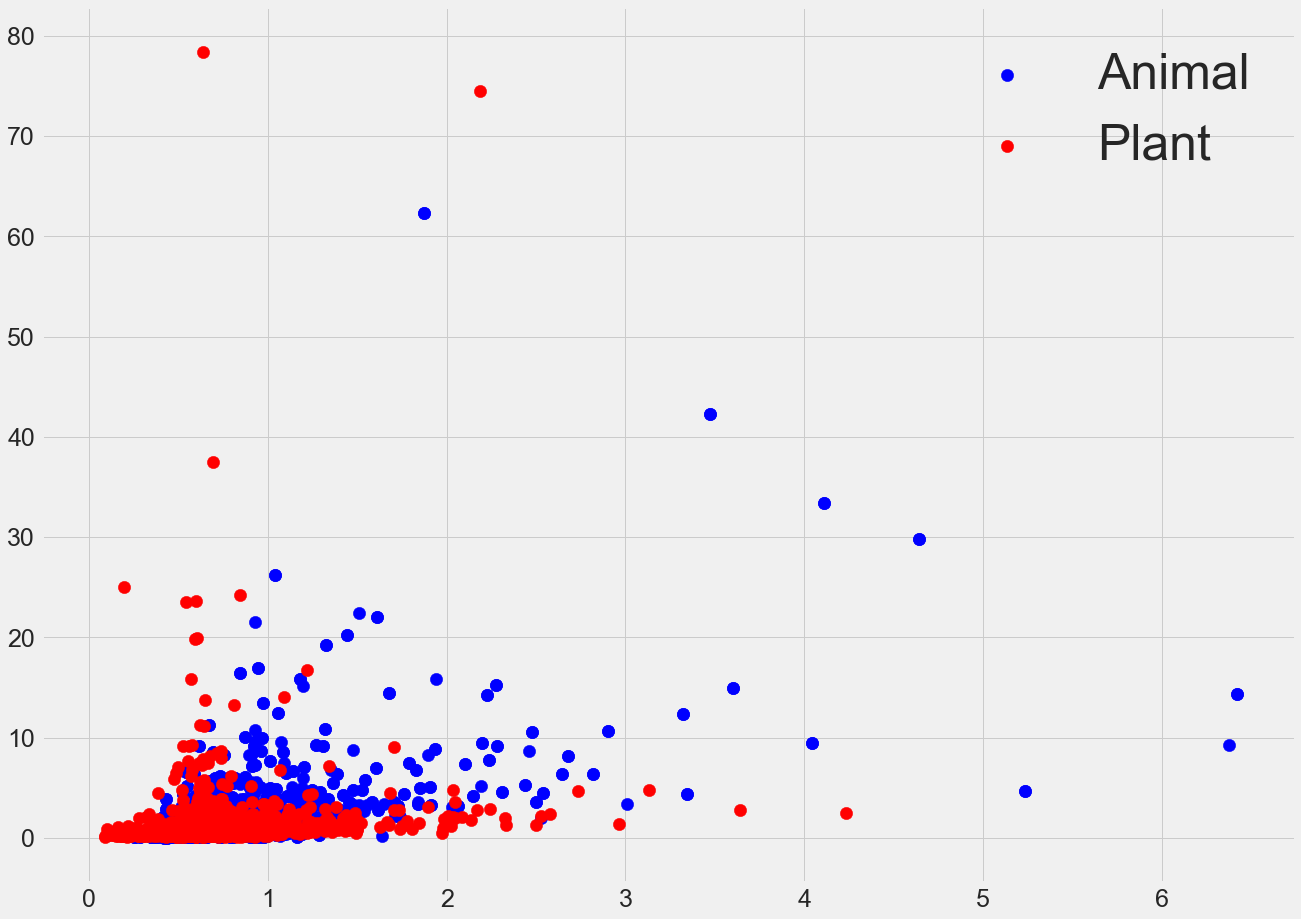

In [5]:
plot([animal_training, plant_training], 'beta.ave', 'gamma.ave', "beta_ave_gamma_ave")

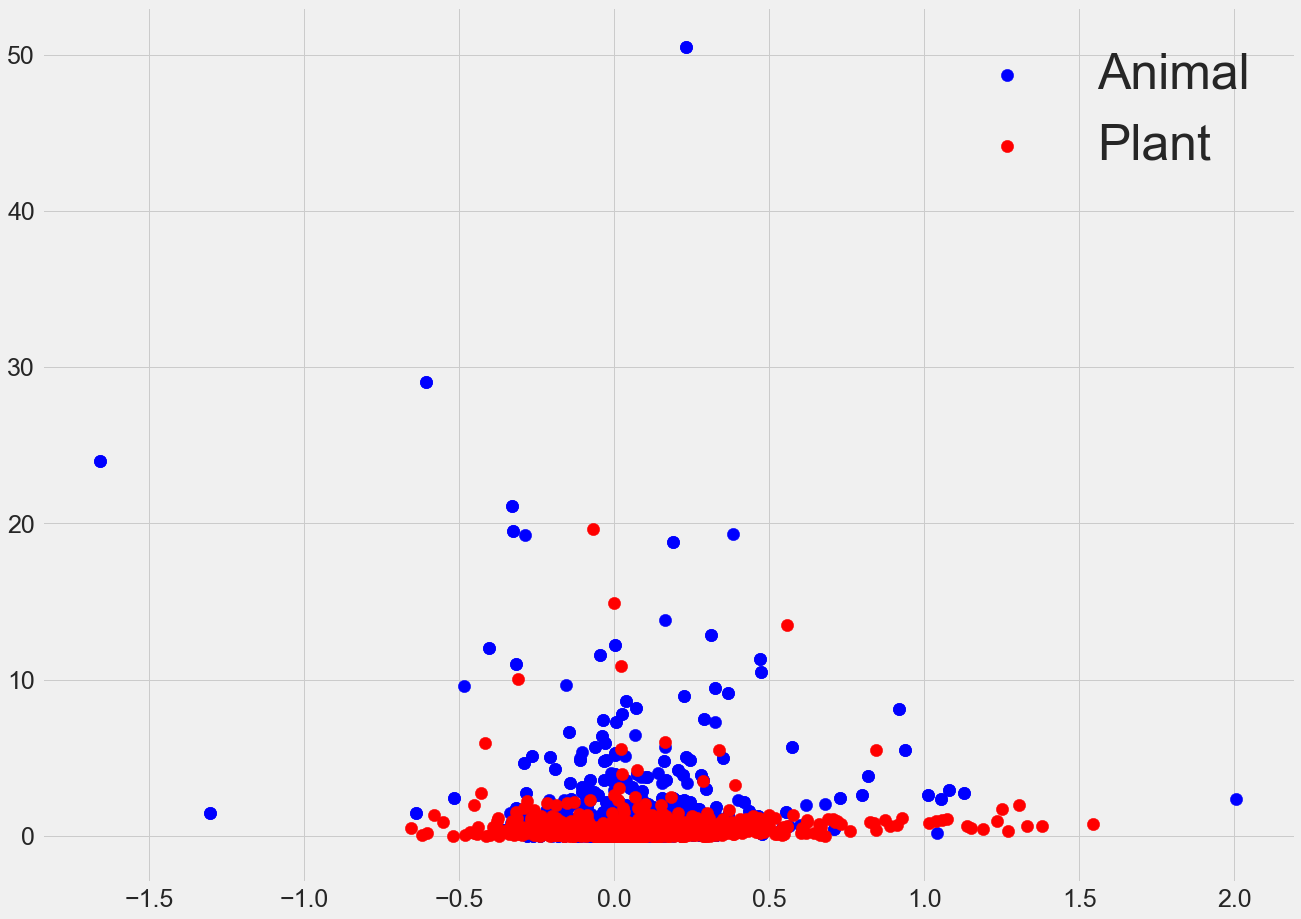

In [6]:
plot([animal_training, plant_training], 'beta.diff', 'gamma.diff', "beta_diff_v_gamma_diff")

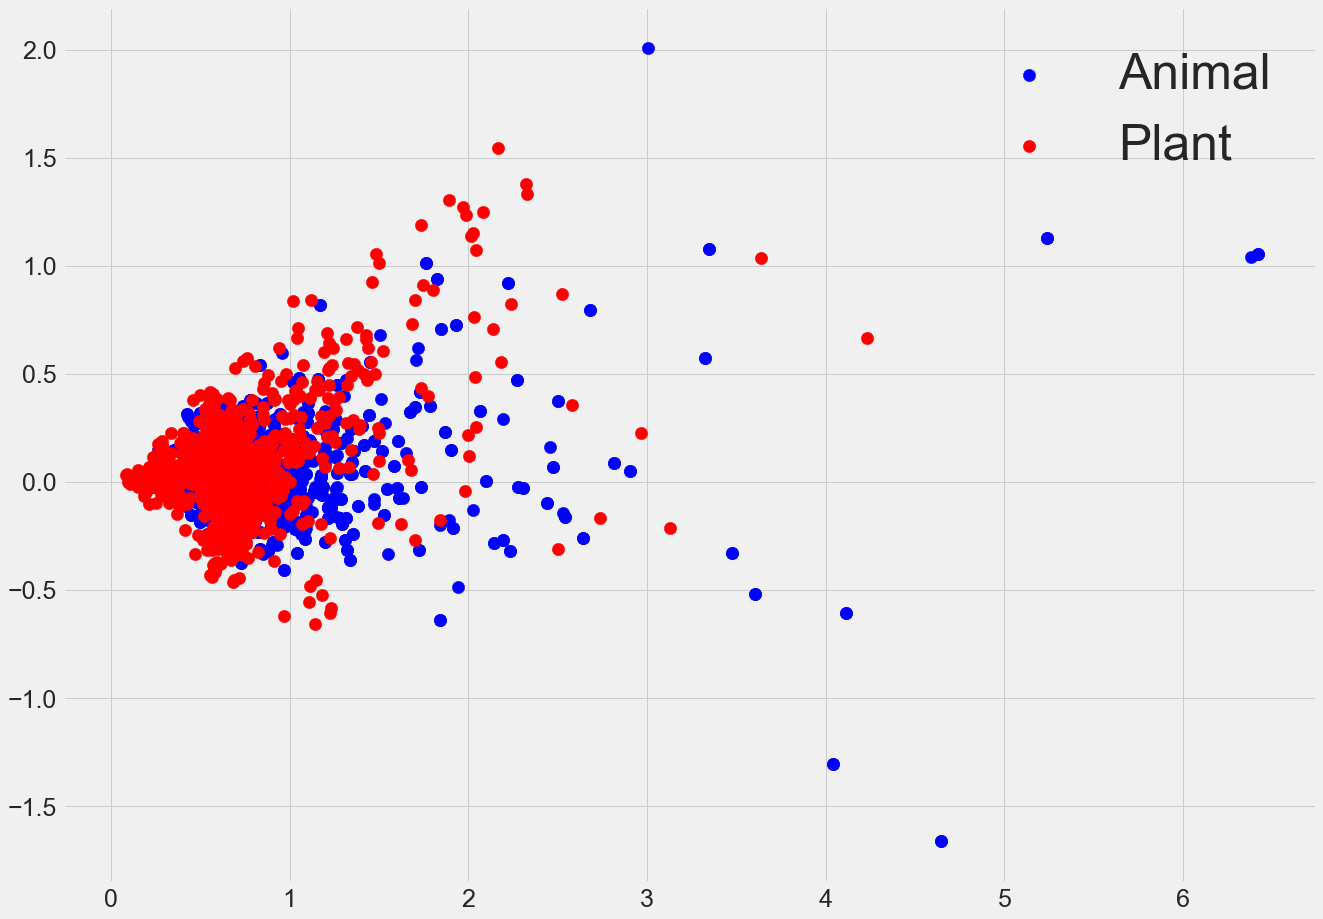

In [7]:
plot([animal_training, plant_training], 'beta.ave', 'beta.diff', "beta_ave_v_beta_diff")

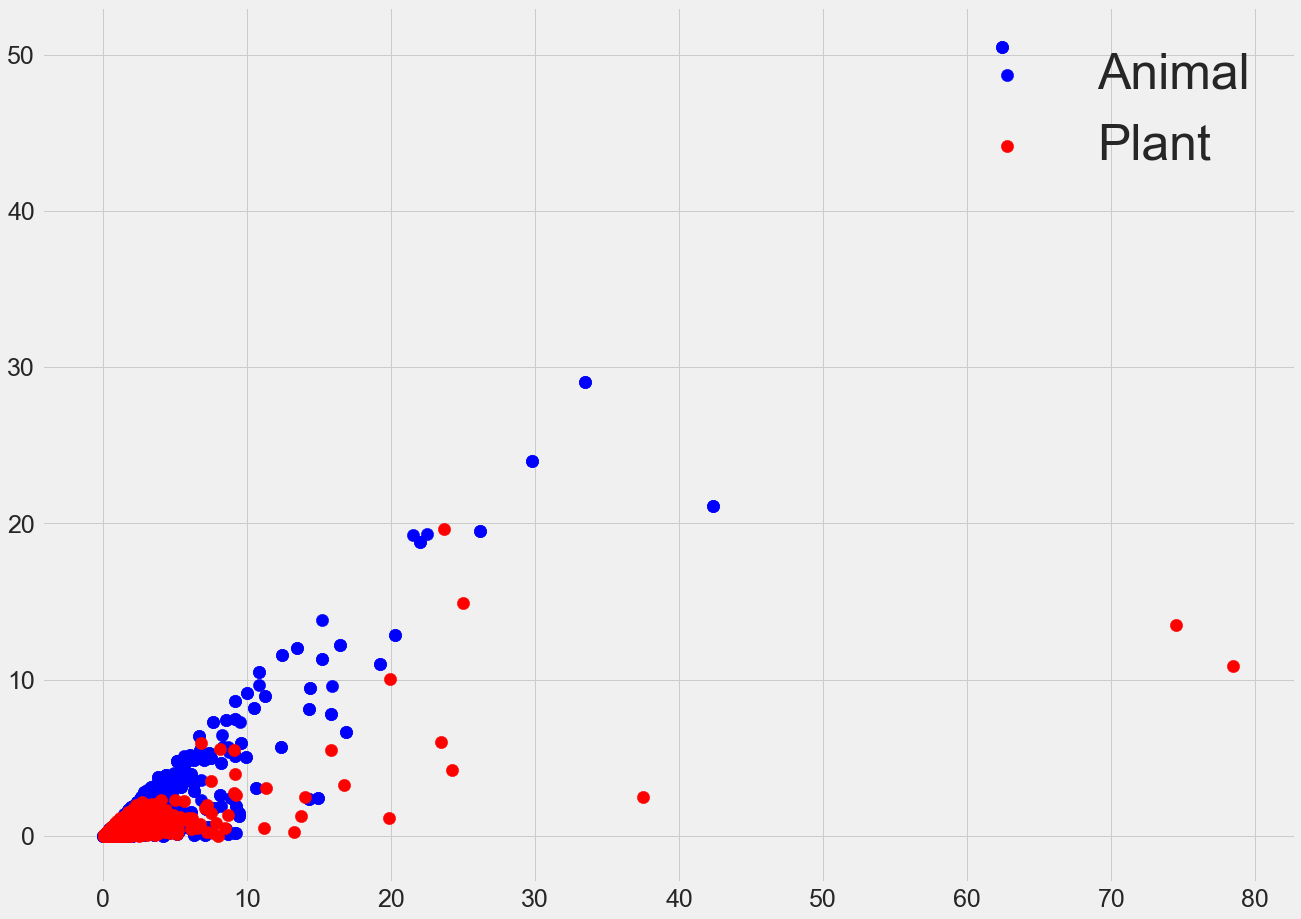

In [8]:
plot([animal_training, plant_training], 'gamma.ave', 'gamma.diff', "gamma_ave_v_gamma_diff")

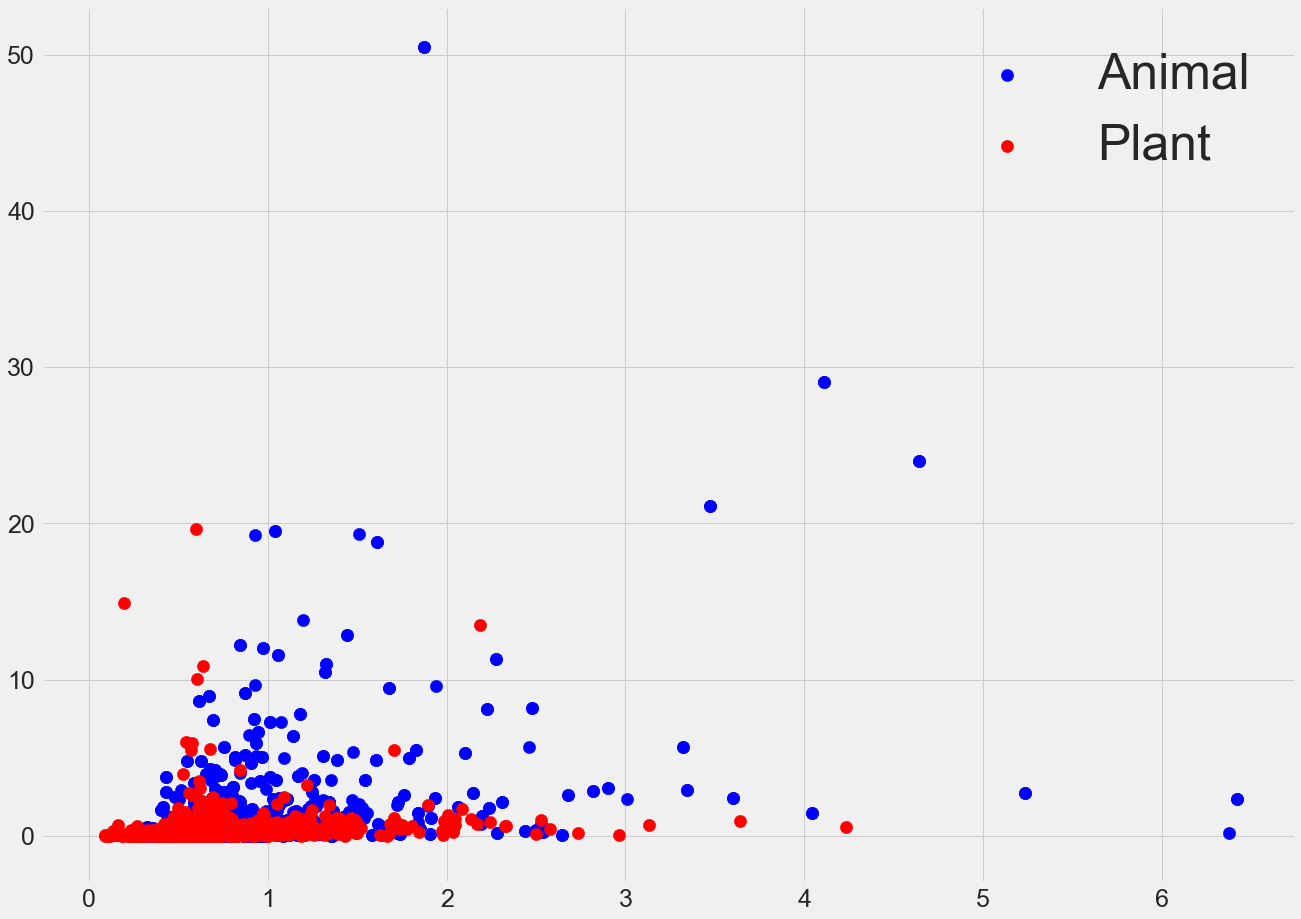

In [9]:
plot([animal_training, plant_training], 'beta.ave', 'gamma.diff', 'beta_ave_v_gamma_diff')

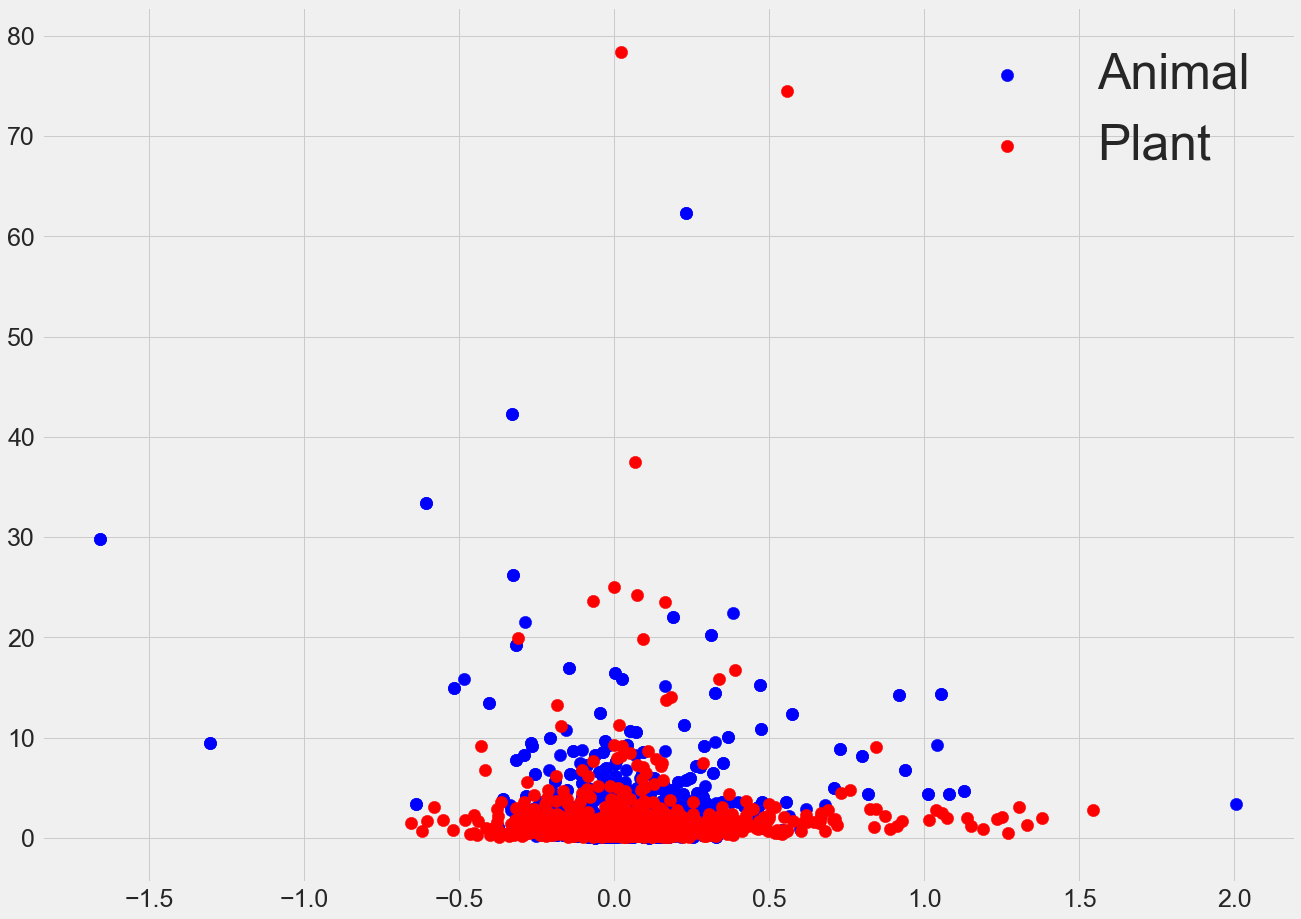

In [10]:
plot([animal_training, plant_training], 'beta.diff', 'gamma.ave', 'beta_diff_v_gamma_diff')

#### Generate Full Training and Testing Set 

In [11]:
training, testing = generate_train_test([animal_training, plant_training], [animal_testing, plant_testing], "animal_v_plant")

### Support Vector Machines

In [117]:
# CREDITS: 
def plot_svc_decision_function(model, ax=None):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--']) 
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [116]:
# training_x1 and training_x2 are beta.ave, gamma.ave, beta.diff, or gamma.diff
def SVM(training, testing, x1, x2, ker, deg):
    X = [training[x1].as_matrix(), training[x2].as_matrix()]
    X = np.transpose(X)
    Y = training['type'].as_matrix()
    clf = SVC(kernel=ker, degree = deg)
    clf.fit(X, Y)
    colors = {1:'r', 0:'b'}
    figure = plt.figure(figsize = (20,15))
    plt.scatter(X[:, 0], X[:, 1], c = training["type"].map(colors), s=150)
    plot_svc_decision_function(clf)
    figure.savefig("svm.png", dpi = 300)
    print(clf.score(np.transpose([testing[x1].as_matrix(),testing[x2].as_matrix()]), testing['type'].as_matrix()))

0.6


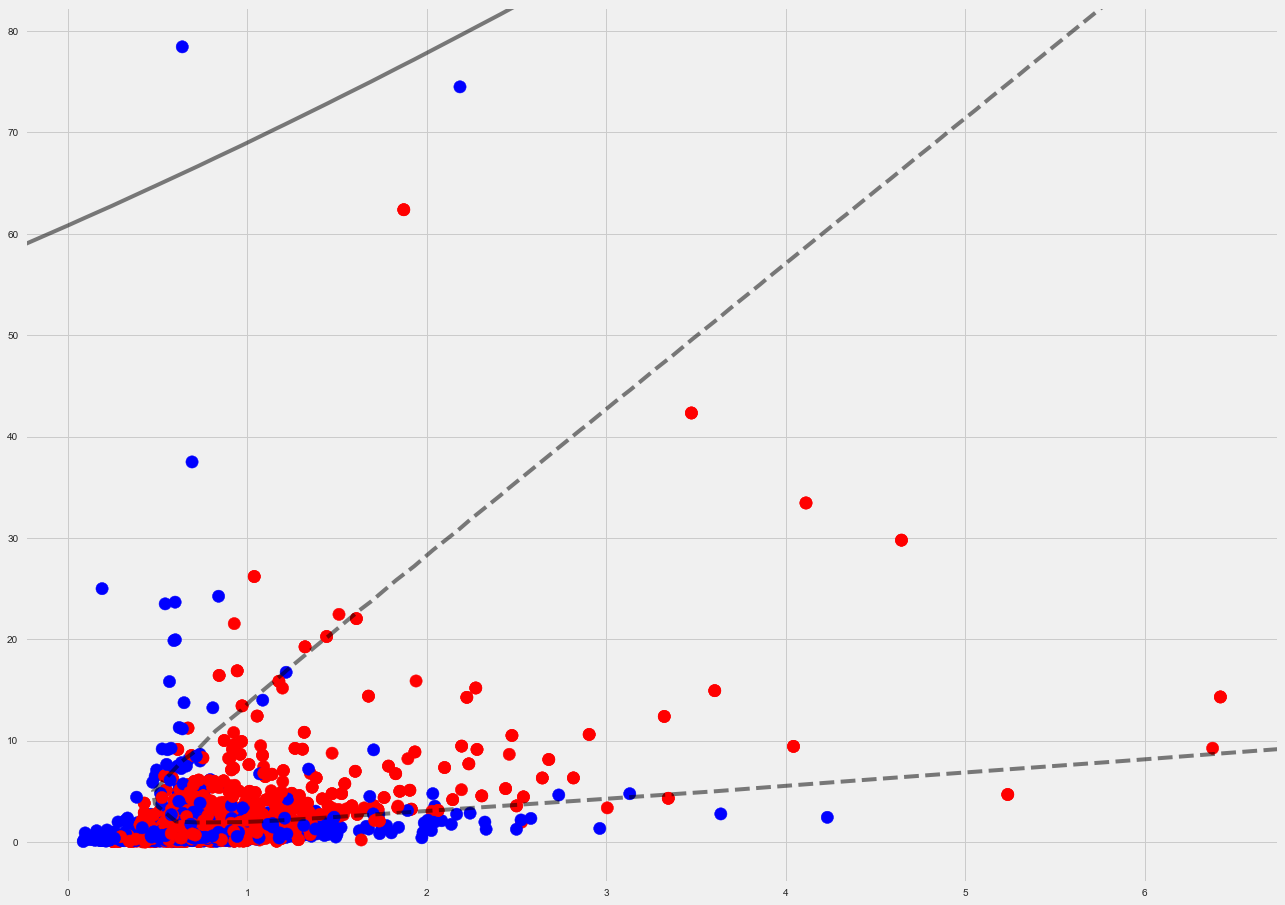

In [118]:
SVM(training, testing, 'beta.ave', 'gamma.ave', 'poly', 2)

In [119]:
# CREDITS: 
def plot_svc_decision_function(model, ax=None):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    # plot decision boundary and margins
    #ax.contour(X, Y, P, colors='k',
    #           levels=[-1, 0, 1], alpha=0.5,
    #           linestyles=['--', '-', '--']) 
    ax.contour(xx1, xx2, yy, levels=[.5], colors=['c'])
    contour = ax.contourf(xx1, xx2, yy, 100, cmap="RdBu",vmin=0, vmax=1)
    ax_c = figure.colorbar(contour) 
    ax_c.ax.tick_params(labelsize=25)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

NameError: global name 'xx1' is not defined

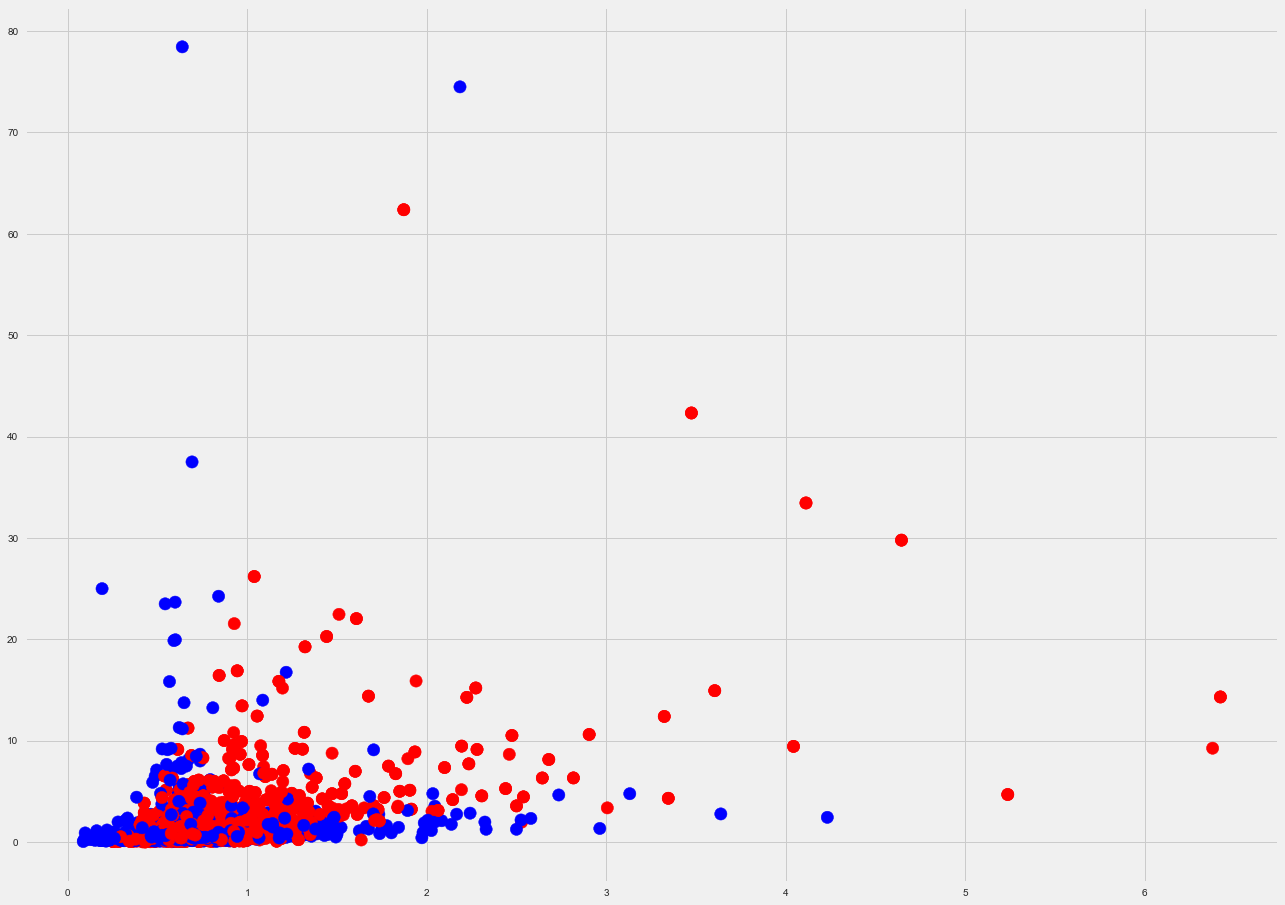

In [120]:
SVM(training, testing, 'beta.ave', 'gamma.ave', 'poly', 2)

### Logistic Regression

In [15]:
# Options for func: exp, rec, poly_3, poly_2, lin
colors = {1:'r', 0:'b'}
def LogReg(training, testing, x1, x2, func):
    names = [x1, x2]
    plt.show()
    if func == "poly_2":
        names.extend([ "X1^2", "X2^2", "XY", "1"])
        training["X1^2"] = training[x1]**2
        training["X2^2"] = training[x2]**2
        training["XY"] = training[x1]*training[x2]
        training["1"] = np.ones(training.shape[0])
    if func == "poly_3":
        names.extend(["X1^2", "X2^2", "X1^3", "X2^3", "X1^2*X2", "X1*X2^2", "1"])
        training['X1^3'] = (training[x1])**3
        training['X2^3'] = (training[x2])**3
        training['X1^2'] = (training[x1])**2
        training['X2^2'] = (training[x2])**2
        training['X1^2*X2'] = (training[x1]**2)*training[x2]
        training['X1*X2^2'] = training[x1]*(training[x2]**2)
        training["1"] = np.ones(training.shape[0])
    if func == "poly_4":
        names.extend(["X1^2", "X2^2", "X1^3", "X2^3", "X1^4", "X2^4"])
        training['X1^4'] = (training[x1])**4
        training['X2^4'] = (training[x2])**4
        training['X1^3'] = (training[x1])**3
        training['X2^3'] = (training[x2])**3
        training['X1^2'] = (training[x1])**2
        training['X2^2'] = (training[x2])**2
    if func == "eli":
        names.extend(["X1^2", "X2^2"])
        training["X1^2"] = training[x1]**2
        training["X2^2"] = training[x2]**2
    if func == "rec":
        names.extend(["1/X2"])
        training["1/X2"] = (1/(-1)*training[x2])
    if func == "exp":
        names.extend([ "e^X2"])
        training["e^X2"] = np.exp((-1)*training[x2])
    if func == "trig":
        names.extend(['sin(X1)', 'cos(X2)'])
        training['sin(X1)'] = np.sin(training[x1])
        training['cos(X2)'] = np.cos(training[x2])
    X = training[names]
    y = training['type']
    logreg = LogisticRegression()
    model = logreg.fit(X,y)
    plt_logreg(model, X, y, x1, x2, func)
    print(logreg.score(X.values,y))
    

In [60]:
def plt_logreg(model, X, y, x1, x2, func):
    #Select data
    X_data = X.values
    x_axis_name = x1
    y_axis_name = x2
    #Create grid
    GRANULARITY = 50
    x1_min, x1_max, x2_min, x2_max = (training[x_axis_name].min(),training[x_axis_name].max(),training[y_axis_name].min(),training[y_axis_name].max())
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, GRANULARITY), np.linspace(x2_min, x2_max, GRANULARITY))
    xx1_col = xx1.ravel()
    xx2_col = xx2.ravel()
    #Predict
    yy = None
    if func == 'poly_2':
        yy = model.predict_proba(np.c_[xx1_col, xx2_col, xx1_col**2, xx2_col**2, xx1_col*xx2_col, np.ones(len(xx1_col))]).T[0]
    if func == 'poly_3':
        yy = model.predict_proba(np.c_[xx1_col, xx2_col ,xx1_col**2, xx2_col**2,xx1_col**3, xx2_col**3, (xx1_col**2)*xx2_col, xx1_col*(xx2_col**2), np.ones(len(xx1_col))]).T[0]
    if func == 'poly_4':
        yy = model.predict_proba(np.c_[xx1_col, xx2_col ,xx1_col**2, xx2_col**2,xx1_col**3, xx2_col**3, xx1_col**4, xx2_col**4]).T[0]
    if func == 'rec':
        yy = model.predict_proba(np.c_[xx1_col, xx2_col, 1/xx2_col]).T[0]
    if func == 'exp':
        yy = model.predict_proba(np.c_[xx1_col, xx2_col, np.exp((-1)*xx2_col)]).T[0]
    if func == 'trig':
        yy = model.predict_proba(np.c_[xx1_col, xx2_col, np.sin(xx1_col), np.cos(xx2_col)])
    if func == "eli":
        yy = model.predict_proba(np.c_[xx1_col, xx2_col, xx1_col**2, xx2_col**2])
    yy = yy.reshape(xx1.shape)
    #Plot figure
    figure = plt.figure(figsize = (20,15))
    ax = figure.add_subplot(1,1,1)
    ax.set_xlim(x1_min, x1_max)
    ax.set_ylim(x2_min, x2_max)
    #ax.set_xlabel(x1)
    #ax.set_ylabel(x2)
    ax.tick_params(axis = 'y', labelsize = 25)
    ax.tick_params(axis='x', labelsize=25)
    #Plot contours
    ax.contour(xx1, xx2, yy, levels=[.5], colors=['c'])
    contour = ax.contourf(xx1, xx2, yy, 100, cmap="RdBu",vmin=0, vmax=1)
    ax_c = figure.colorbar(contour) 
    ax_c.ax.tick_params(labelsize=25)
    #Plot scatter plot
    ax.scatter(training[x_axis_name],training[y_axis_name], c = training['type'].map(colors), s = 150) 
    figure.savefig("Logistic_regression_poly_2.png", dpi = 300)
    plt.show()

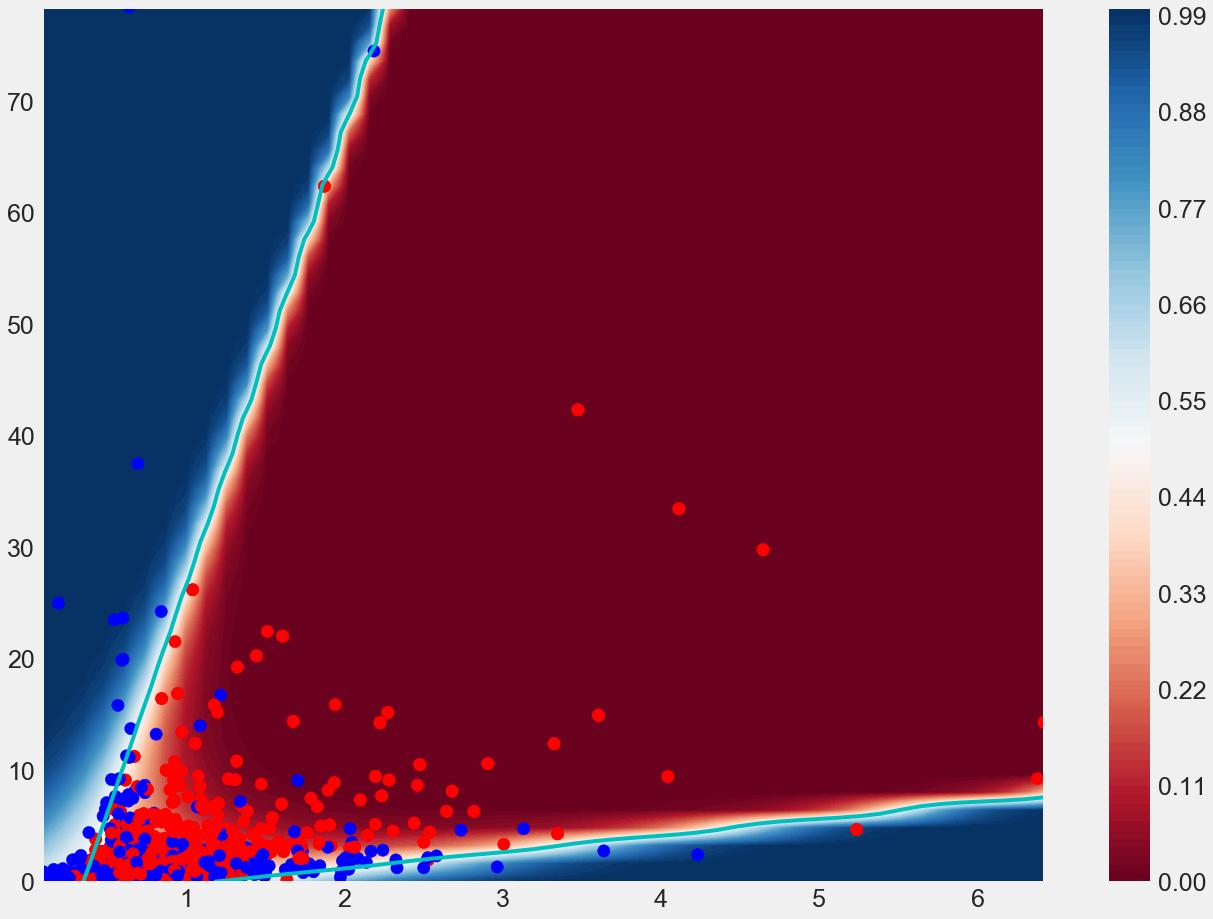

0.63080495356


In [61]:
LogReg(training, testing, 'beta.ave', 'gamma.ave', 'poly_2')

# Three-Dimensional Fit (Including Scaling Exponent Data)

### PCA

In [18]:
def PCA(training, testing, x1, x2):
    print("")

In [19]:
#https://stats.stackexchange.com/questions/144439/applying-pca-to-test-data-for-classification-purposes
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris

# load data
iris = load_iris()

# initiate PCA and classifier
pca = PCA()
classifier = DecisionTreeClassifier()

# transform / fit

X_transformed = pca.fit_transform(iris.data)
classifier.fit(X_transformed, iris.target)

# predict "new" data
# (I'm faking it here by using the original data)

newdata = iris.data

# transform new data using already fitted pca
# (don't re-fit the pca)
newdata_transformed = pca.transform(newdata)

# predict labels using the trained classifier

pred_labels = classifier.predict(newdata_transformed)

1. Search paramater space
1. Figure out how to export graphs
1. Cross-validation
1. Check color region of various datasets to see if there is bias for which type
1. Add 3rd dimension with scaling exponents conservation/ratio (ask Alex)
1. PCA